# https://bit.ly/3CbrI8K

# Google Colab & Google Drive

In [ ]:
!nvidia-smi

Sat Nov  2 02:31:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/nida

/content/drive/MyDrive/nida


# Basic CNN for MNIST dataset

In [ ]:
import torch
import torchvision

In [ ]:
batch_size_train = 64
batch_size_test = 1000

train_dataset = torchvision.datasets.MNIST(
    '/files/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    '/files/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size_test, shuffle=False)

In [ ]:
(example_data, example_targets) = train_dataset[0]

In [ ]:
example_data.shape, example_targets

(torch.Size([1, 28, 28]), 0)

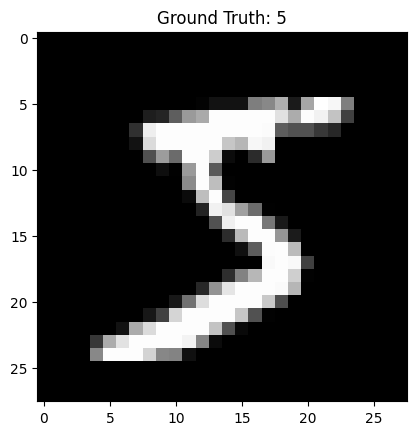

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(example_data[0], cmap='gray')
plt.title("Ground Truth: {}".format(example_targets))
plt.show()

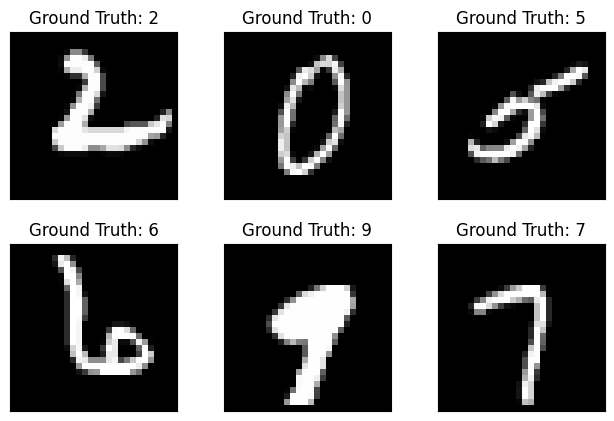

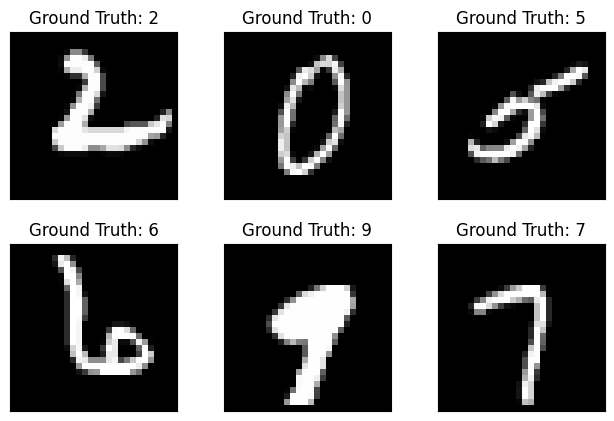

In [ ]:
import matplotlib.pyplot as plt

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Building Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # input 1 channel, 8 filters = output 8 channels, output same size as input
        self.conv2 = nn.Conv2d(8, 10, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(490, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # (batch_size, 1, 28,28) -> conv1 -> (batch_size, 8, 28,28) -> max_pool2d -> (batch_size, 8, 14, 14)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # (batch_size, 8, 14,14) -> conv2 -> (batch_size, 10, 14,14) -> dropout -> (batch_size, 10, 14,14) -> max_pool2d -> (batch_size, 10, 7,7)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # "flatten" >> arrange all values on the feature maps as a single vector >> 490 values
        x = x.view(-1, x.size(dim=1)*x.size(dim=2)*x.size(dim=3))

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [ ]:
model = CNN()

x = torch.rand((1,1,28,28))
model(x).argmax()

tensor(6)

In [ ]:
import tqdm

def train_epoch(model, optimizer, data_loader, device):

  model.train()
  model.to(device)
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar := tqdm.tqdm_notebook(data_loader)):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    output = model(data)              # predict output for current data
    loss = F.nll_loss(output, target) # compute loss
    loss.backward()                   # backprop to get gradient

    optimizer.step()                  # update the model

    train_loss += loss

    if (batch_idx+1) % 100 == 0:
      pbar.set_description('Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        batch_idx * len(data), len(data_loader.dataset),
        100. * batch_idx / len(data_loader), loss.item()))

  return train_loss

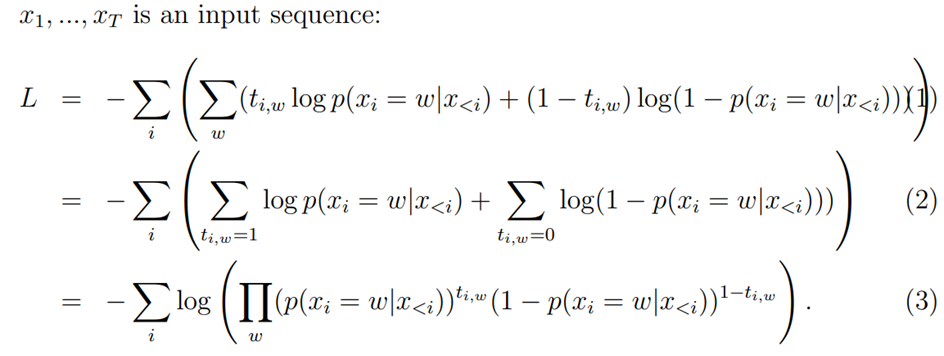

In [ ]:
def test(model, data_loader, device):
  model.eval()
  model.to(device)
  test_loss = 0
  correct = 0
  with torch.no_grad(): # no need for gradient >>not allocate additional variables
    for data, target in data_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(data_loader.dataset)
  test_acc = 100. * correct / len(data_loader.dataset)
  return test_acc, test_loss

In [ ]:
from tqdm import trange

network = CNN()

# training config
n_epochs = 3
learning_rate = 0.01

optimizer = optim.Adam(network.parameters(), lr=learning_rate)

best_acc = 0
for epoch in (pbar := trange(1, n_epochs + 1)):
  train_epoch(network, optimizer, train_loader, device)
  test_acc, test_loss = test(network, test_loader, device)
  if test_acc > best_acc:
    pbar.set_description('Test accracy improves from {:.2f} to {:.2f}'.format(best_acc, test_acc))
    best_acc = test_acc

    torch.save(network.state_dict(), 'model.pth')
    torch.save(optimizer.state_dict(), 'optimizer.pth')

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-20-a93d5f4e8b02>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(pbar := tqdm.tqdm_notebook(data_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Test accracy improves from 0.00 to 97.16:  33%|███▎      | 1/3 [00:23<00:47, 23.85s/it]

  0%|          | 0/938 [00:00<?, ?it/s]

Test accracy improves from 0.00 to 97.16:  67%|██████▋   | 2/3 [00:44<00:21, 21.99s/it]

  0%|          | 0/938 [00:00<?, ?it/s]

Test accracy improves from 97.16 to 97.40: 100%|██████████| 3/3 [01:06<00:00, 22.09s/it]


## Train with custom Dataset

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class MyDataset(Dataset):

    def __init__(self):
        self.dataset = train_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        bitmap, cls = self.dataset[idx]

        return {
            "pixels": torch.tensor(bitmap),
            "label": cls
        }

In [ ]:
train_dataset = MyDataset()
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

In [ ]:
import tqdm

model = CNN()
#model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loss = 0
for batch_idx, data in enumerate(pbar := tqdm.tqdm_notebook(train_loader)):
  data, target = data["pixels"], data["label"]

  optimizer.zero_grad()

  output = model(data)              # predict output for current data
  loss = F.nll_loss(output, target) # compute loss
  loss.backward()                   # backprop to get gradient

  optimizer.step()                  # update the model

  train_loss += loss

  if (batch_idx+1) % 100 == 0:
    pbar.set_description('Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      batch_idx * len(data), len(train_loader.dataset),
      100. * batch_idx / len(train_loader), loss.item()))


## Use pre-trained vision model

In [ ]:
!pip install timm

In [ ]:
from timm.models import create_model

In [ ]:
import timm

for i,n in enumerate(timm.list_models('*')):
  print(i, n)

0 bat_resnext26ts
1 beit_base_patch16_224
2 beit_base_patch16_384
3 beit_large_patch16_224
4 beit_large_patch16_384
5 beit_large_patch16_512
6 beitv2_base_patch16_224
7 beitv2_large_patch16_224
8 botnet26t_256
9 botnet50ts_256
10 caformer_b36
11 caformer_m36
12 caformer_s18
13 caformer_s36
14 cait_m36_384
15 cait_m48_448
16 cait_s24_224
17 cait_s24_384
18 cait_s36_384
19 cait_xs24_384
20 cait_xxs24_224
21 cait_xxs24_384
22 cait_xxs36_224
23 cait_xxs36_384
24 coat_lite_medium
25 coat_lite_medium_384
26 coat_lite_mini
27 coat_lite_small
28 coat_lite_tiny
29 coat_mini
30 coat_small
31 coat_tiny
32 coatnet_0_224
33 coatnet_0_rw_224
34 coatnet_1_224
35 coatnet_1_rw_224
36 coatnet_2_224
37 coatnet_2_rw_224
38 coatnet_3_224
39 coatnet_3_rw_224
40 coatnet_4_224
41 coatnet_5_224
42 coatnet_bn_0_rw_224
43 coatnet_nano_cc_224
44 coatnet_nano_rw_224
45 coatnet_pico_rw_224
46 coatnet_rmlp_0_rw_224
47 coatnet_rmlp_1_rw2_224
48 coatnet_rmlp_1_rw_224
49 coatnet_rmlp_2_rw_224
50 coatnet_rmlp_2_rw_384
5

In [ ]:
for i,n in enumerate(timm.list_models('*', pretrained=True)):
  print(i,n)

0 bat_resnext26ts.ch_in1k
1 beit_base_patch16_224.in22k_ft_in22k
2 beit_base_patch16_224.in22k_ft_in22k_in1k
3 beit_base_patch16_384.in22k_ft_in22k_in1k
4 beit_large_patch16_224.in22k_ft_in22k
5 beit_large_patch16_224.in22k_ft_in22k_in1k
6 beit_large_patch16_384.in22k_ft_in22k_in1k
7 beit_large_patch16_512.in22k_ft_in22k_in1k
8 beitv2_base_patch16_224.in1k_ft_in1k
9 beitv2_base_patch16_224.in1k_ft_in22k
10 beitv2_base_patch16_224.in1k_ft_in22k_in1k
11 beitv2_large_patch16_224.in1k_ft_in1k
12 beitv2_large_patch16_224.in1k_ft_in22k
13 beitv2_large_patch16_224.in1k_ft_in22k_in1k
14 botnet26t_256.c1_in1k
15 caformer_b36.sail_in1k
16 caformer_b36.sail_in1k_384
17 caformer_b36.sail_in22k
18 caformer_b36.sail_in22k_ft_in1k
19 caformer_b36.sail_in22k_ft_in1k_384
20 caformer_m36.sail_in1k
21 caformer_m36.sail_in1k_384
22 caformer_m36.sail_in22k
23 caformer_m36.sail_in22k_ft_in1k
24 caformer_m36.sail_in22k_ft_in1k_384
25 caformer_s18.sail_in1k
26 caformer_s18.sail_in1k_384
27 caformer_s18.sail_i

In [ ]:
model = timm.create_model('resnet50d', pretrained=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [ ]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [ ]:
# it's possible to adapt existing model for different input channels
# useful when we want to retrain the model on grayscale images
model = timm.create_model('resnet50d', pretrained=True, in_chans=1)

x = torch.rand((1,1,224,224)) # batch, channels, height, width

model(x).size()

In [ ]:
import timm

model = timm.create_model('resnet50d', pretrained=True)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [ ]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

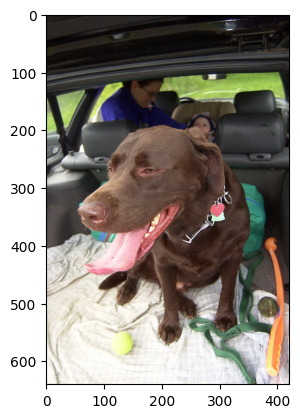

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

url = "https://farm1.staticflickr.com/15/18770229_42b4101aa0_z.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
plt.imshow(image)

In [ ]:
input_tensor = transform(image)

In [ ]:
input_tensor.shape

torch.Size([3, 224, 224])

In [ ]:
input_tensor.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

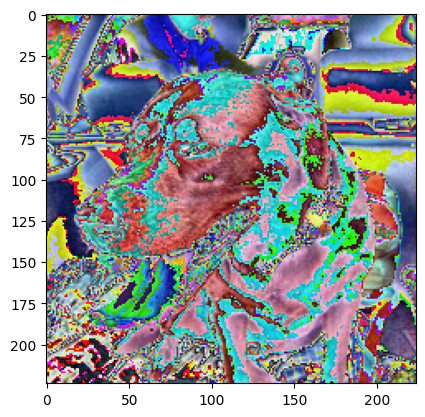

In [ ]:
import torchvision.transforms as T

tr = T.ToPILImage()

plt.imshow(tr(input_tensor))

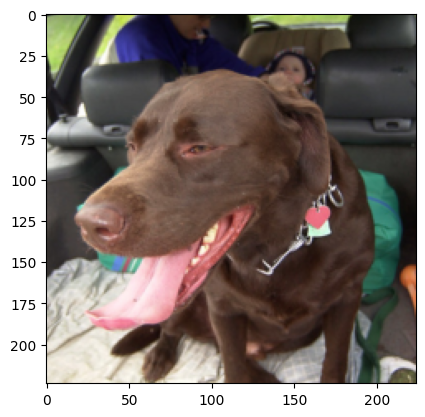

In [ ]:
tr = T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=(224, 224)),
])

img = tr(image)

plt.imshow(img)

In [ ]:
out = model(input_tensor.unsqueeze(0))
out.topk(10, dim=1)

torch.return_types.topk(
values=tensor([[0.5835, 0.5647, 0.5562, 0.4929, 0.4232, 0.4212, 0.4211, 0.4083, 0.3878,
         0.3561]], grad_fn=<TopkBackward0>),
indices=tensor([[180, 209, 215, 220, 208, 808, 186, 636, 427, 205]]))

In [ ]:
# adapt pretrained model to custom data
import timm

custom_model = timm.create_model('resnet50d', pretrained=True, num_classes=14)
custom_model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

## Explainability: GradCAM

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=a07bab9740d8f9a9d4e674b1283962d4c67dc59be7614e06795c1814a6522c99
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [ ]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

array([[[ 21,  22,  86],
        [ 22,  23,  87],
        [ 23,  26,  87],
        ...,
        [ 34,  38, 103],
        [ 31,  37,  95],
        [ 55,  64,  98]],

       [[ 30,  34,  93],
        [ 35,  40,  97],
        [ 44,  50, 104],
        ...,
        [ 40,  43, 108],
        [ 34,  38, 100],
        [ 45,  51,  99]],

       [[ 62,  70, 116],
        [ 69,  78, 119],
        [ 72,  83, 119],
        ...,
        [ 45,  47, 113],
        [ 38,  41, 106],
        [ 38,  41,  97]],

       ...,

       [[114, 158, 233],
        [115, 158, 233],
        [116, 159, 233],
        ...,
        [ 55,  52, 156],
        [ 48,  47, 150],
        [ 42,  43, 148]],

       [[116, 160, 233],
        [117, 160, 234],
        [116, 160, 234],
        ...,
        [ 57,  53, 157],
        [ 46,  45, 146],
        [ 40,  40, 143]],

       [[118, 162, 234],
        [117, 161, 233],
        [116, 161, 234],
        ...,
        [ 61,  56, 163],
        [ 45,  43, 147],
        [ 43,  42, 144]]], dtype=uint8)
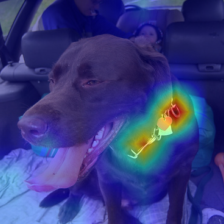

In [ ]:
import numpy as np

cam = GradCAM(model=model, target_layers=[model.layer4[-1]])

grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(808)])

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np.asarray(img)/255, grayscale_cam, use_rgb=True)
visualization

In [ ]:
import timm

model = timm.create_model('deit_tiny_patch16_224', pretrained=True)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
transform

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

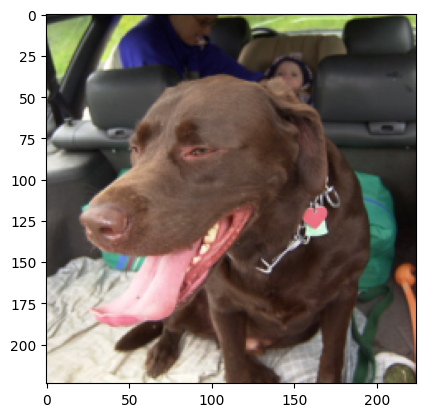

In [ ]:
tr = T.Compose([
    T.Resize(size=248),
    T.CenterCrop(size=(224, 224)),
])

img = tr(image)

plt.imshow(img)

In [ ]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [ ]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

array([[[ 22,  22,  86],
        [ 22,  22,  86],
        [ 23,  23,  86],
        ...,
        [ 84, 104, 111],
        [ 85, 104, 114],
        [ 86, 106, 116]],

       [[ 25,  26,  88],
        [ 25,  26,  88],
        [ 26,  26,  88],
        ...,
        [ 86, 106, 114],
        [ 88, 107, 119],
        [ 87, 107, 119]],

       [[ 19,  19,  84],
        [ 16,  16,  81],
        [ 15,  14,  81],
        ...,
        [ 83, 100, 111],
        [ 86, 104, 118],
        [ 87, 104, 118]],

       ...,

       [[124, 121, 181],
        [123, 119, 180],
        [123, 120, 179],
        ...,
        [ 43,  43,  92],
        [ 37,  35,  88],
        [ 31,  23,  81]],

       [[123, 120, 180],
        [122, 118, 179],
        [123, 119, 179],
        ...,
        [ 41,  40,  90],
        [ 38,  37,  88],
        [ 33,  27,  83]],

       [[122, 118, 179],
        [121, 118, 178],
        [121, 118, 179],
        ...,
        [ 44,  41,  92],
        [ 41,  39,  90],
        [ 37,  32,  86]]], dtype=uint8)
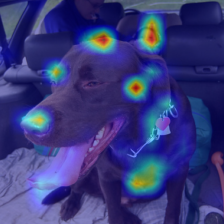

In [ ]:
cam = GradCAM(model=model, target_layers=[model.blocks[-1].norm1], reshape_transform=reshape_transform)

grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(180)])

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np.asarray(img)/255, grayscale_cam, use_rgb=True)
visualization

# NLP

## Pipeline

In [ ]:
from transformers import pipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
classifier = pipeline("text-classification", device="cuda") # default model for sentiment analyis

text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

import pandas as pd

output = classifier(text)
pd.DataFrame(output)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,label,score
0,NEGATIVE,0.901546


In [ ]:
ner_tagger = pipeline("ner", aggregation_strategy="simple", device="cuda")
outputs = ner_tagger(text)
pd.DataFrame(outputs)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,entity_group,score,word,start,end
0,ORG,0.879010,Amazon,5,11
1,MISC,0.990859,Optimus Prime,36,49
2,LOC,0.999755,Germany,90,97
3,MISC,0.556569,Mega,208,212
4,PER,0.590257,##tron,212,216
5,ORG,0.669693,Decept,253,259
6,MISC,0.498349,##icons,259,264
7,MISC,0.775361,Megatron,350,358
8,MISC,0.987854,Optimus Prime,367,380
9,PER,0.812096,Bumblebee,502,511


In [ ]:
reader = pipeline("question-answering", device="cuda")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,score,start,end,answer
0,0.631292,335,358,an exchange of Megatron


In [ ]:
summarizer = pipeline("summarization", device="cuda")
outputs = summarizer(text, max_length=60, clean_up_tokenization_spaces=True)
print(outputs[0]["summary_text"])

In [ ]:
generator = pipeline("text-generation")
response = "Dear Bumblebee, I am sorry to hear that your order was mixed up."

prompt = text + "\n\nCustomer service response:\n" + response

outputs = generator(prompt, max_length=200)
print(outputs[0]["generated_text"])

No model was supplied, defaulted to openai-community/gpt2 and revision 6c0e608 (https://huggingface.co/openai-community/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Dear Amazon, last week I ordered an Optimus Prime action figure from your online store in Germany. Unfortunately, when I opened the package, I discovered to my horror that I had been sent an action figure of Megatron instead! As a lifelong enemy of the Decepticons, I hope you can understand my dilemma. To resolve the issue, I demand an exchange of Megatron for the Optimus Prime figure I ordered. Enclosed are copies of my records concerning this purchase. I expect to hear from you soon. Sincerely, Bumblebee.

Customer service response:
Dear Bumblebee, I am sorry to hear that your order was mixed up. As I noted here at Bumblebee, it is difficult for me to process this problem since the retailer did not send along an appropriate order file. I will contact the local Autobot shop and get confirmation. I received your order in my mail yesterday as planned, but when I opened the package my mailbox was filled with the same letters


In [ ]:
# A100
translator = pipeline("translation", model="google/madlad400-3b-mt", device="cuda")

In [ ]:
outputs = translator("<2th> " + text, max_length=400)
print(outputs[0]['translation_text'])

In [ ]:
vqa_model = pipeline("visual-question-answering")
image_url = "https://huggingface.co/datasets/Narsil/image_dummy/raw/main/lena.png"
vqa_model(question="What is she wearing ?", image=image_url)

In [ ]:
captioner = pipeline("image-to-text", device="cuda")
captioner("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/lena.png")

In [ ]:
caption = captioner("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/lena.png")

outputs = translator("<2th> " + caption[0]["generated_text"], max_length=400)
print(outputs[0]['translation_text'])

### Hugging Face components
- Models
- Tokenizers
- Datasets
- Metrics


## Wongnai Reviews

In [ ]:
!pip -q install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install -q emoji pythainlp sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
!pip install --no-deps thai2transformers==0.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for thai2transformers: filename=thai2transformers-0.1.2-py3-none-any.whl size=28114 sha256=8453a2ef2d0452754c473f93a991cd4cfdffce799eb2c807a4d0e959e345f334
  Stored in directory: /root/.cache/pip/wheels/2c/4b/b2/a90368d80567249f258a9c58240512046afb5563d794eda4b2
Successfully built thai2transformers


In [ ]:
from datasets import load_dataset
dataset = load_dataset('wongnai_reviews')
dataset

README.md:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6203 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 6203
    })
})

In [ ]:
dataset["train"][0]

{'review_body': 'ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้ำก่อนเลย เออแปลกดี \nห้องทานหลักๆอยู่ชั้น 2 มีกาแฟ น้ำผึ้ง ซึ่งก็แค่เอาน้ำผึ้งมาราด แพงเวอร์ อย่าสั่งเลย \nลาบไข่ต้ม ไข่มันคาวอะ เลยไม่ประทับใจเท่าไหร่\nทอดมันหัวปลีกรอบอร่อยต้องเบิ้ล \nพะแนงห่อไข่อร่อยดี เห้ยแต่ราคา 150บาทมันเกินไปนะ รับไม่ไหวว\nเลิกกินแล้วมีขนมหวานให้กินฟรีเล็กน้อย )ขนมไทย) \n\nคงไม่ไปซ้ำ แพงเกิน ',
 'star_rating': 2}

In [ ]:
from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
model = BertForSequenceClassification.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

You are using a model of type camembert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(25005, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
#pipeline
from transformers import pipeline

classify_multiclass = pipeline(task='text-classification', tokenizer=tokenizer, model=model, device="cuda")

In [ ]:
# WangchanBERTa official Colab uses this stuff
from thai2transformers.preprocess import process_transformers
input_text = process_transformers(dataset["train"][3]['review_body'])
input_text

'รัานคัพเค้กในเมืองไทยมีไม่มาก<_>หลายๆคนอาจจะสงสัยว่าคัพเค้กคืออะไร<_>ต่างจากเค้กธรรมดาอย่างไร<_>จริงๆแล้วคัพเค้กก็เป็น<_>รูปแบบ<_>หนึ่งของเค้กนั่นแหละครับ<_>แต่ว่าคัพเค้กจะมีจุดเด่นอยู่ที่รสชาติที่เป็นเอกลักษณ์<_>เพราะใช้ส่วนผสมของครีมชีสเป็นหลักในการทำหน้าเค้ก<_>หรือที่เรียกว่า<_>frosting<_>นอกจากนั้น<_>คัพเค้กยังถือทานง่าย<_>ขนย้ายง่ายกว่าเค้ก<_>สุดท้ายคือการตกแต่งที่แตกต่างกันอย่างชัดเจนครับระหว่างคัพเค้กกับเค้ก<_>ซึ่งการใช้คัพเค้กที่ตกแต่งสวยๆเพื่อใช้ในงานแต่งงาน<_>งานวันเกิดหรือ<_>event<_>ต่างๆนั้นกำลังมาเลยทีเดียว<_>เรียกได้ว่าคู่ไหน<_>บริษัทไหนอยากฮิป<_>ก็ต้องสั่งคัพเค้กนี่ล่ะครับไปออกงาน<_>event<_>สำหรับร้าน<_>cupcake<_>love<_>นี้เพิ่งเปิดได้ไม่นานตั้งอยู่ที่<_>digital<_>gateway<_>ชั้นสาม<_>เดินทางสะดวกเพราะติดกับทางเชื่อม<_>bts<_>เลย<_>ร้านน่ารักดีครับ<_>เพิ่งเปิดร้านใหม่หลายๆอย่างก็ดูลนๆ<_>แต่ก็ดูคึกคักดี<_>ผมได้ทานครบทุกรสแล้ว<_>รสชาติดีมากเพราะว่าเค้กมันชุ่มจริงๆ<_>ชุ่มกว่าเค้กธรรมดาซะอีก<_>ราคาก็ดีนะที่<_>59<_>บาทต่อชิ้น<_>ได้ทาน<_>pink<_>lemonade<_>(ที่ร้านเรียกว่า<_>lov

In [ ]:
# We need this to handle long text
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':416}

#infer
outputs = classify_multiclass(input_text, **tokenizer_kwargs)

import pandas as pd
pd.DataFrame(outputs)

,label,score
0,LABEL_1,0.539022


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "airesearch/wangchanberta-base-att-spm-uncased",
    num_labels=5,
    problem_type="single_label_classification" # "multi_label_classification"
)

You are using a model of type camembert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.sel

In [ ]:
model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
from datasets import load_dataset
class MyDataset(Dataset):

    def __init__(self):
        self.dataset = dataset["train"]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        item = self.dataset[idx]
        text = item["review_body"]
        tok  = self.tokenizer(text, max_length=128, padding="max_length", truncation=True, return_tensors="pt")

        return {
            "tok": tok["input_ids"][0],
            "label": item["star_rating"]
        }

In [ ]:
train_dataset = MyDataset()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

for epoch in range(1):

  model.train(True)
  for t,batch in enumerate(train_dataloader):
      optimizer.zero_grad()

      out = model(
          input_ids = batch["tok"],
          labels = batch["label"])

      out.loss.backward()

      optimizer.step()
      if (t+1)%100==0:
        print(".", end="", flush=True)

      if t>=20:
        break

__Hugging Face__ has its own _Trainer_ class which offers several advantages over basic training used above.